# WCWH Rollout Preparation
Working to get the beacons ready for their next adventure. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
sys.path.append('../')

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
from src.visualization import visualize

from src.calibration import calibrate

import math
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

%load_ext autoreload
%autoreload 2

# Calibration
With access to higher-grade instruments, we start to look at the possibility of calibrating the sensors to get more-reliable results. We look at two primary ways of calibrating the beacons:

1. Constant/Offset
2. Linear Regression

## Experiment Details
Here are the relevant notes from the calibration experiments:
1. Experiment 1
 - **Start**: datetime(2021,5,10,14,5,0)
 - **End**: datetime(2021,5,10,23,59,0)
 - **Beacons**: [1,2,4,5,6,7,10,11,12,13,14,15,16,19,21]
 - **Events**:
     - 14:15 - 14:25: CO2 cylinder open
     - 14:25 - 14:40: Candle burning
     - 14:40 - 14:50: CO2 cylinder open
     - 14:50 - 15:05: candle burning
 - **Notes**:
     - B26 added at 14:36
2. Experiment 2
 - **Start**: datetime(2021,5,11,16,30,0)
 - **End**: datetime(2021,5,11,17,30,0)
 - **Beacons**: [1,2,4,5,6,7,10,11,12,13,14,15,16,19,21]
 - **Events**:
     - 16:35 - 17:10: Candle and paper burning
     - 16:40 - 16:55: CO2 cylinder open
     
3. Experiment 3
 - **Start**: datetime(2021,5,21,9,23,0)
 - **End**: datetime(2021,5,21,12,23,0)
 - **Beacons**: [1,2,4,5,6,7,9,10,11,12,14,15,16,19,21,23,25,26,28,29]
 - **Events**:
     - 16:35 - 17:10: Candle and paper burning
     
4. Experiment 4
 - **Start**: datetime(2021,6,15,15,21,0)
 - **End**: datetime(2021,6,15,17,21,0)
 - **Beacons**: [1,2,4,5,6,7,9,10,11,12,14,15,16,19,21,23,25,26,28,29]
 - **Events**:
     - 15:22 - 16:02: Unoccupied
     - 16:03 - 16:16 CO2 cylinder open
     - 16:22: Paper Burning

### Defining Calibration Object
We use the `Calibration` class from the UTx000 Project.

In [6]:
c = calibrate.Calibration(datetime(2021,6,22,12,20,0),datetime(2021,6,22,13,20,0),"../data/",study="wcwh_pilot",study_suffix="wcwh_s21",beacons=[1,2,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19,21,23,25,26,28,29])

No file found - try providing a `timestamp` argument instead
IMPORTING REFERENCE DATA
File not found - ../data/calibration/pm_number_06222021.csv
File not found - ../data/calibration/pm_mass_06222021.csv
File not found - ../data/calibration/no2_06222021.csv
File not found - ../data/calibration/no_06222021.csv
File not found - ../data/calibration/co2_06222021.csv
IMPORTING BEACON DATA
Error with file b12_2021-06-15.csv: Error tokenizing data. C error: Expected 22 fields in line 1441, saw 24

Error with file b14_2021-06-15.csv: Error tokenizing data. C error: Expected 19 fields in line 6, saw 24



## Inspection
Some simple functions to inspect measurements

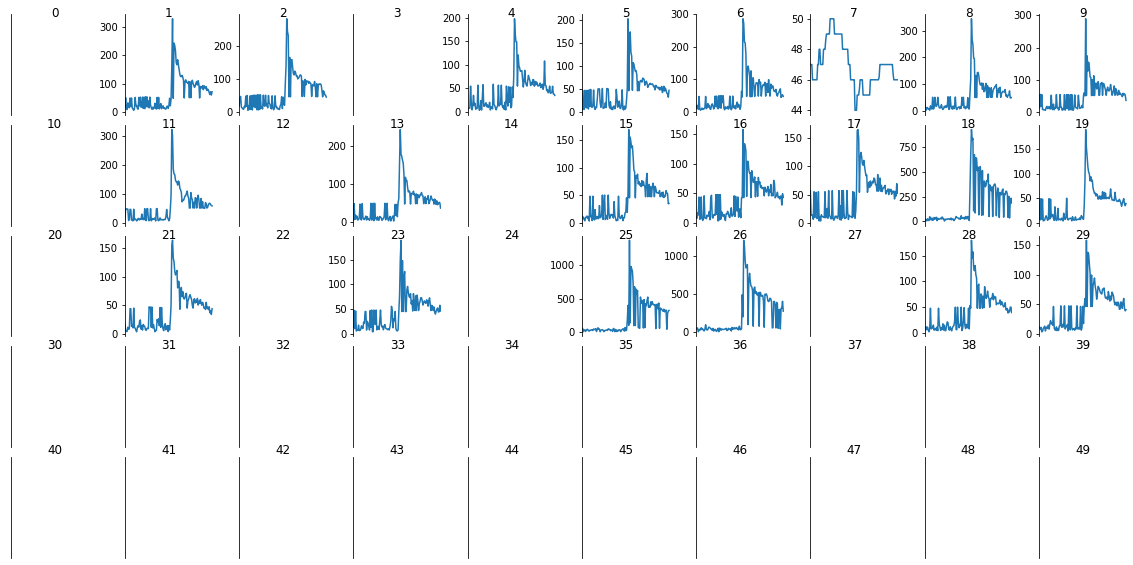

In [4]:
#for var in ["co2","pm2p5_mass","tvoc","co","no2","temperature_c","rh","lux"]:
c.inspect_by_beacon_by_param("pm10_mass")

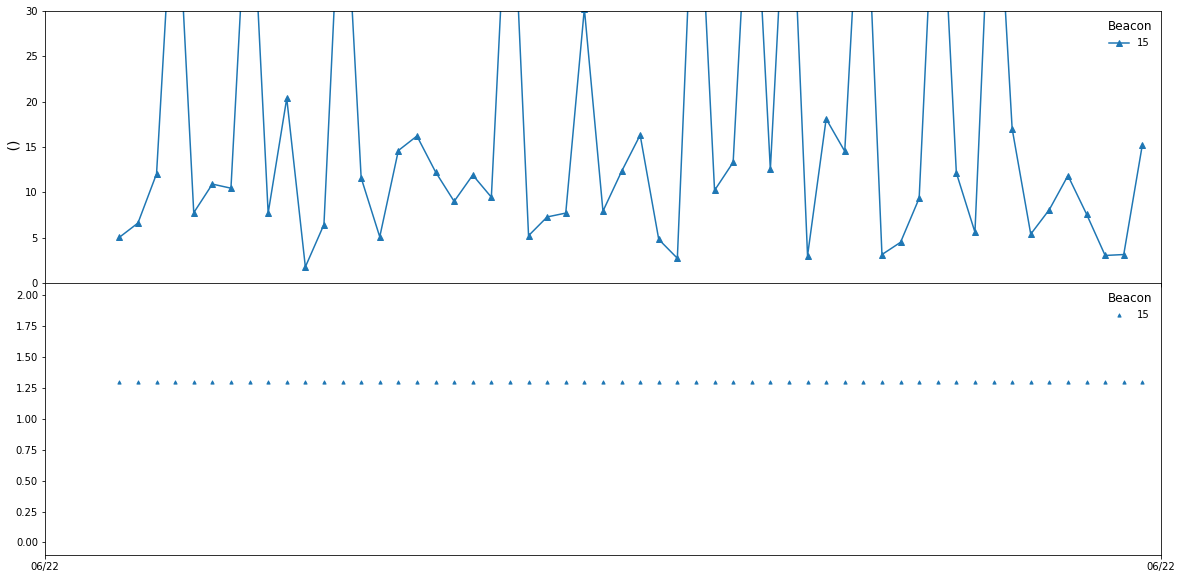

In [10]:
c.inspect_timeseries("pm10_mass",ylimits=[0,30])

## Diagnostics

### Non-Responsive Beacons
The ```get_reporting_beacons``` functions determines which of the beacons that was included in the calibration event are not shown in the following figures because of issues related to power, sensor connection, or VPN connection.

In [5]:
missing, reporting = c.get_reporting_beacons("co")

Missing data from: [12, 14]


## Comparison
As an initial exploration, we can also look into how the beacon measurements relate to the reference measurements. 

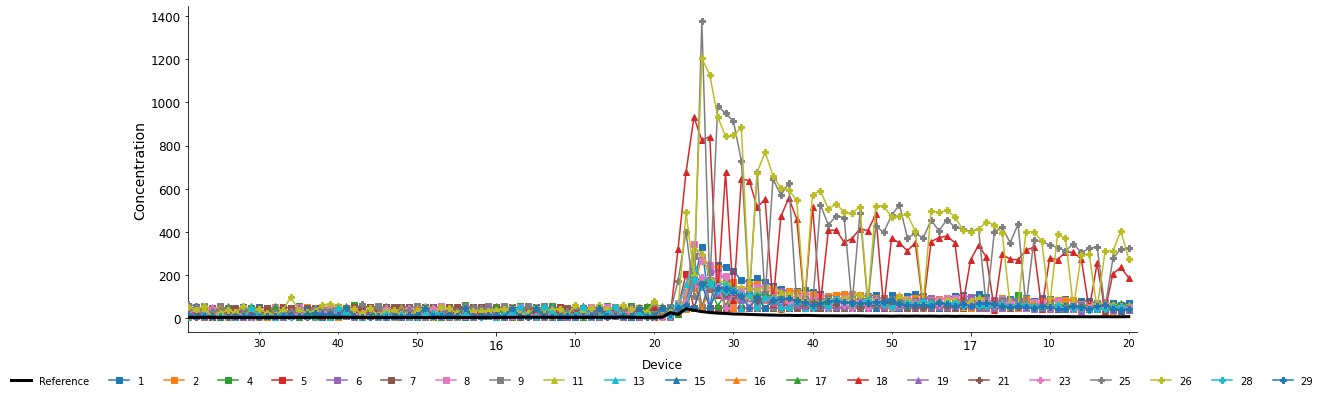

In [5]:
c.compare_time_series("pm10_mass")

## Constant/Offset
For the `co` sensor, we do not have a reference monitor and therefore cannot accurately calibrate this sensor against other measurements. Instead, we can determine a constant offset assuming a clean, background concentration of 0 ppm. 

In [7]:
c.offset("co")

## Linear Model

In [9]:
c.linear_regression("pm10_mass",save_to_file=True)#,event=datetime(2021,6,15,16,22))

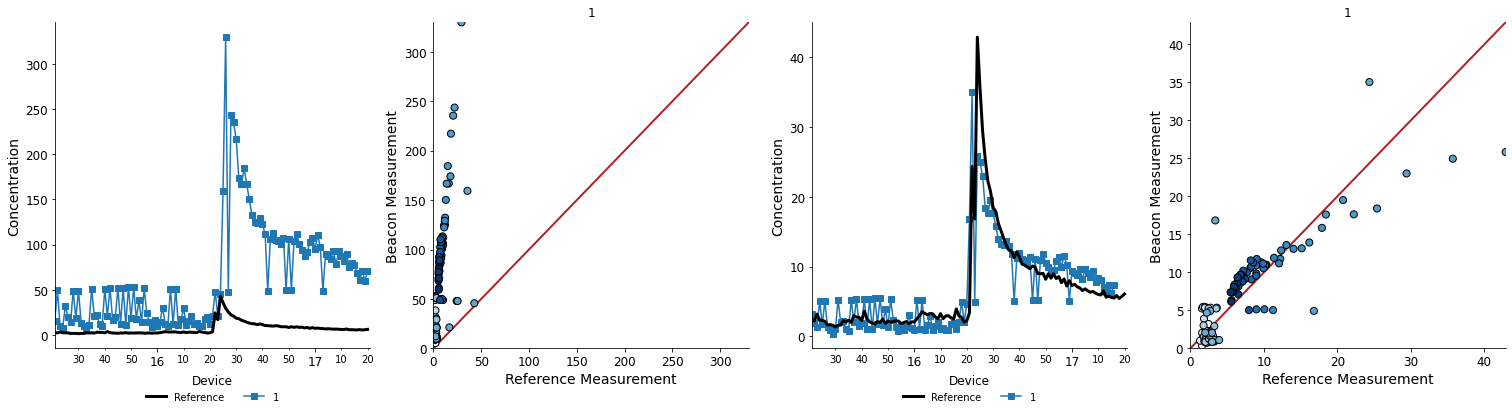

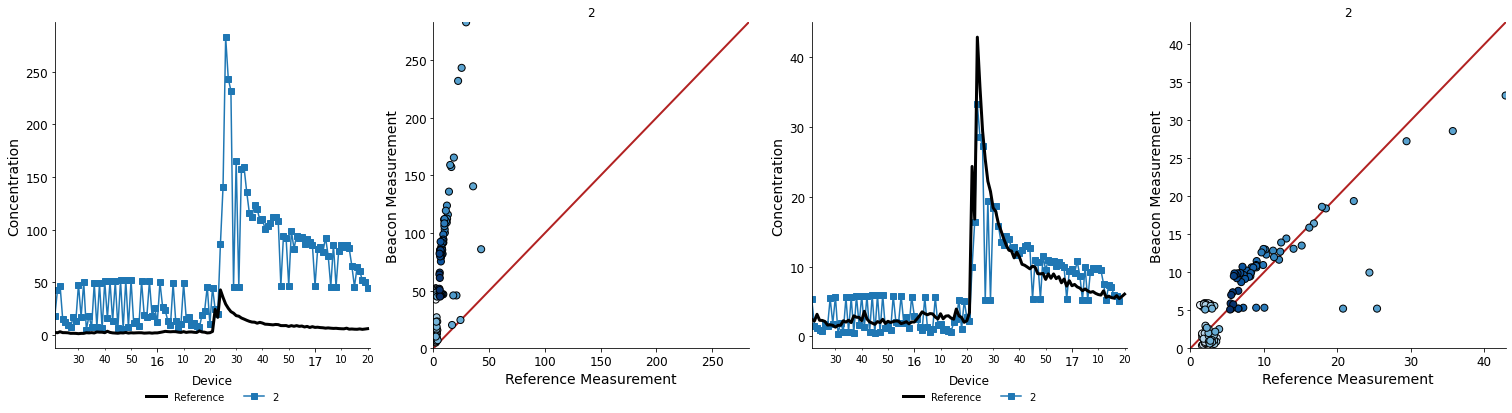

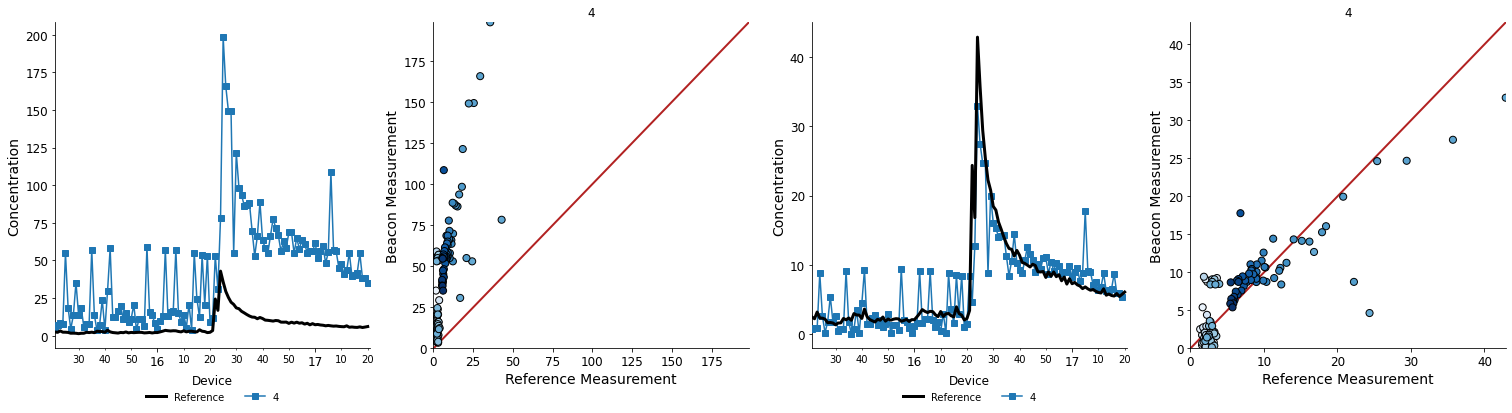

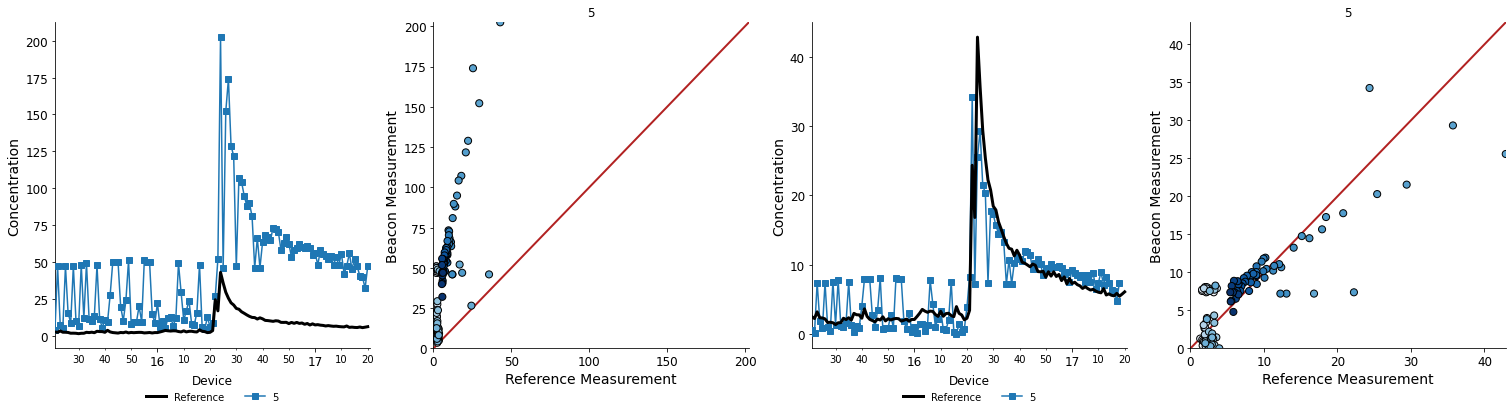

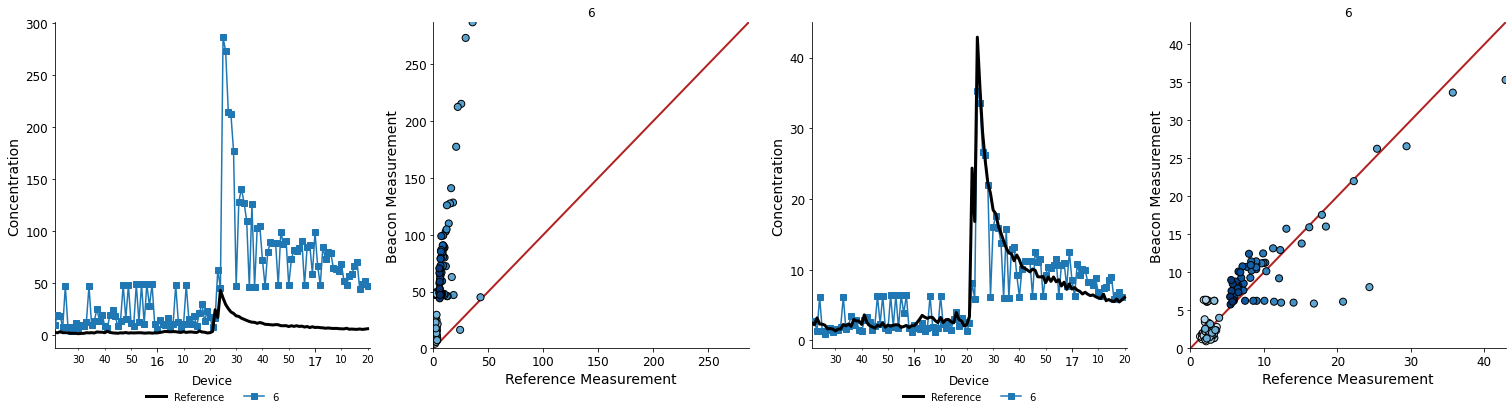

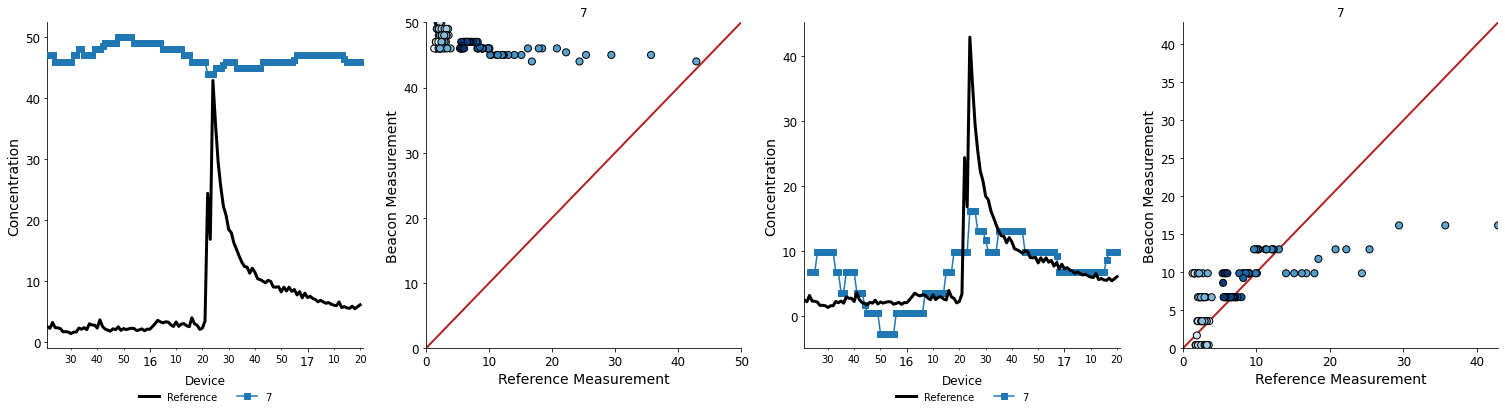

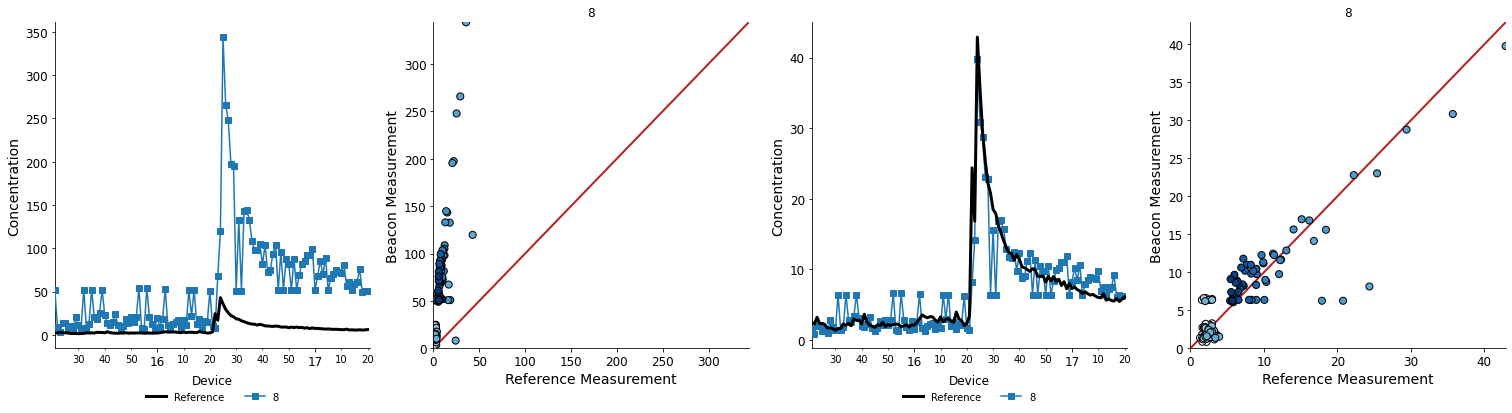

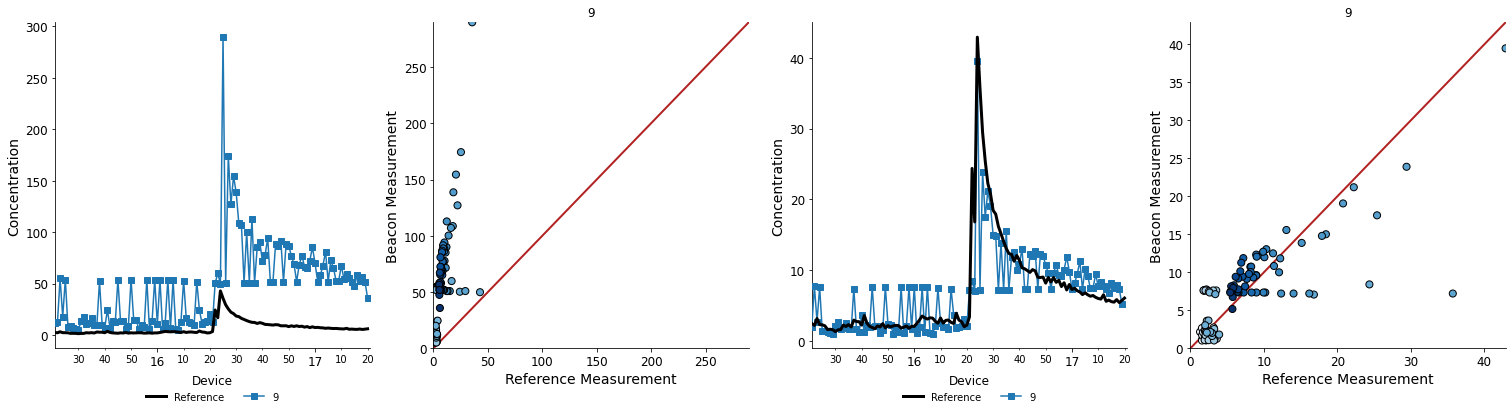

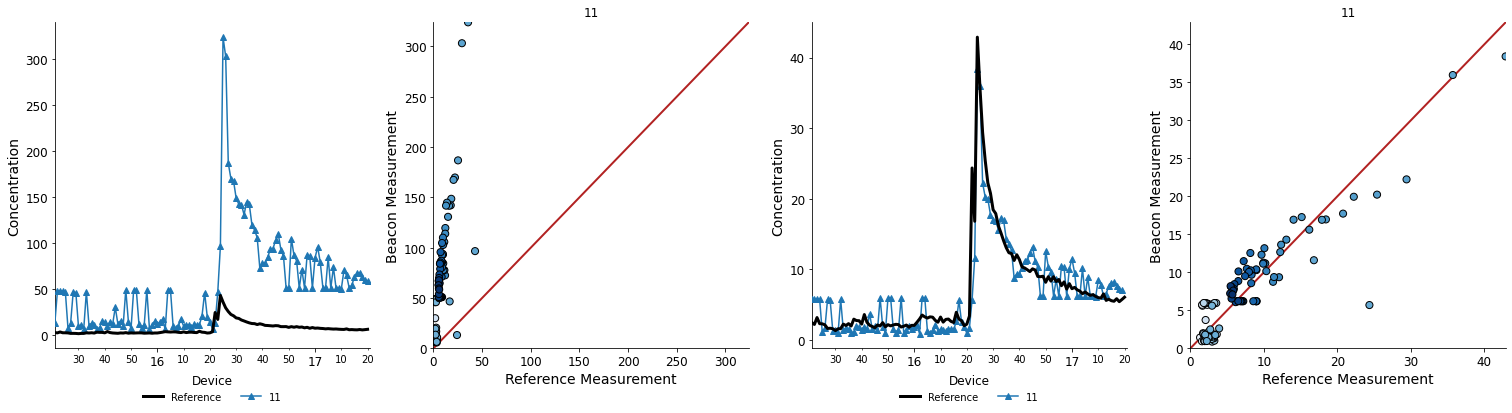

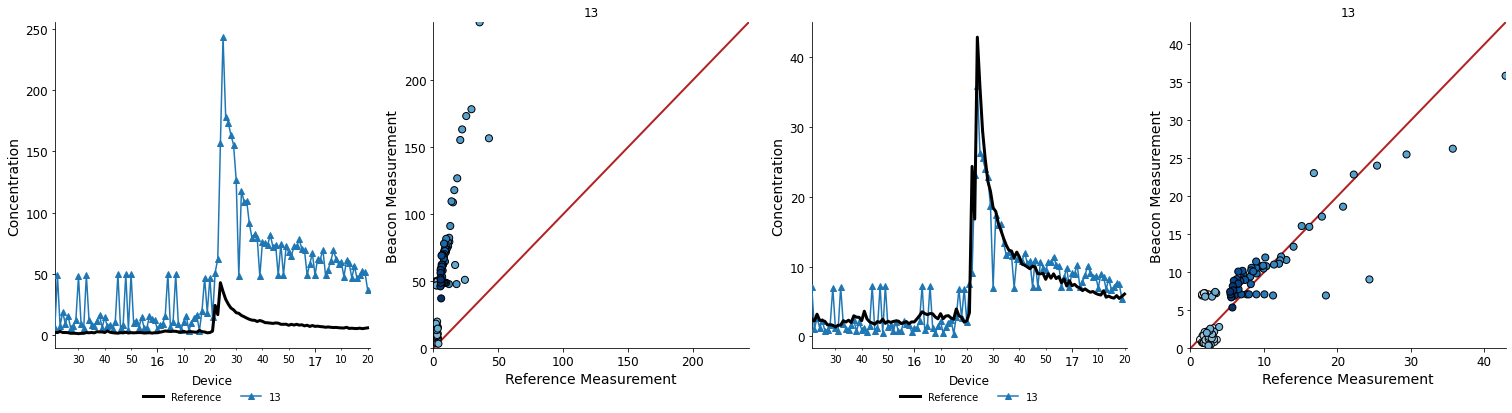

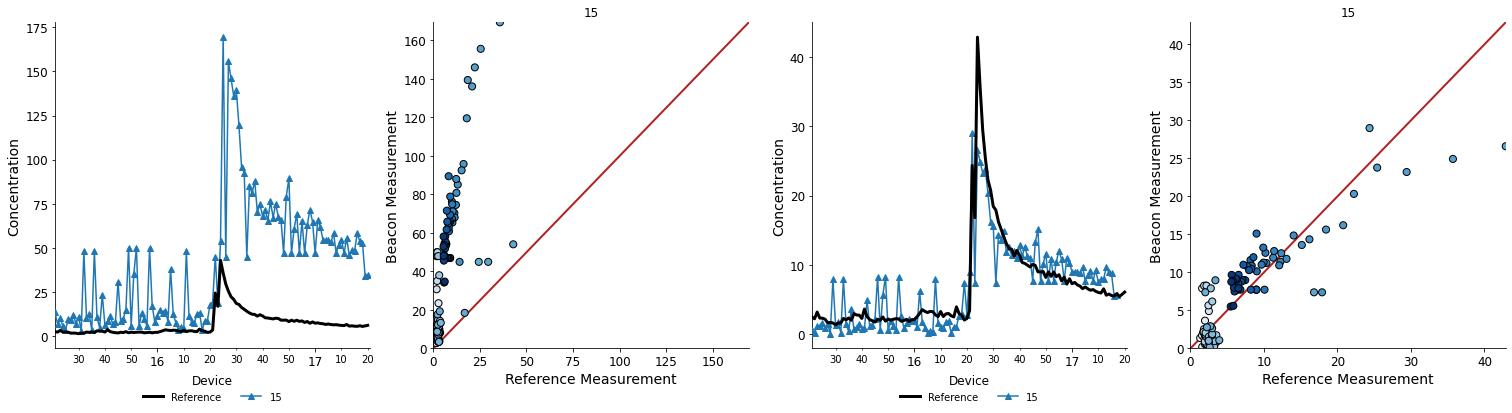

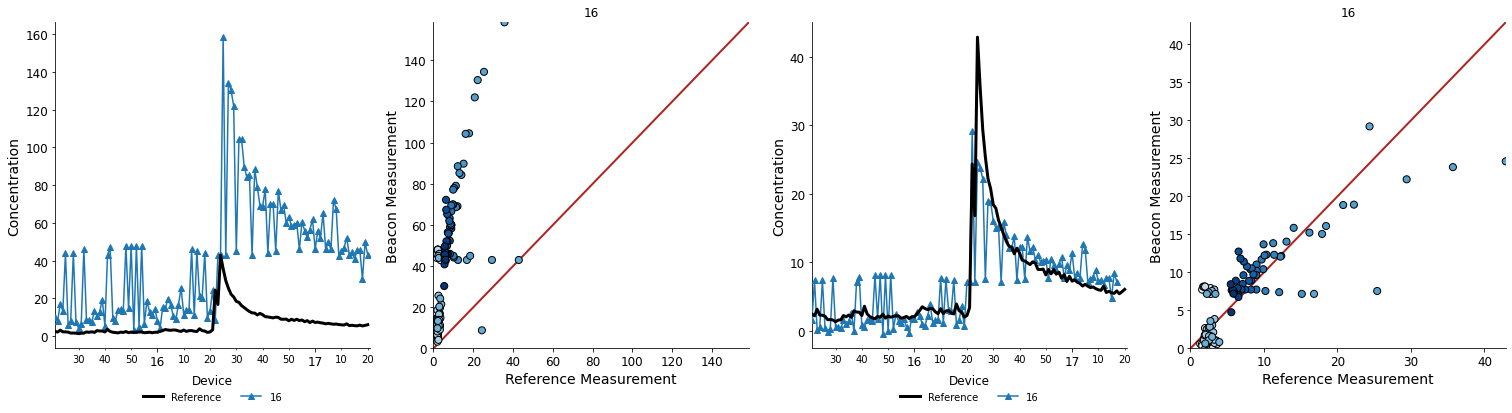

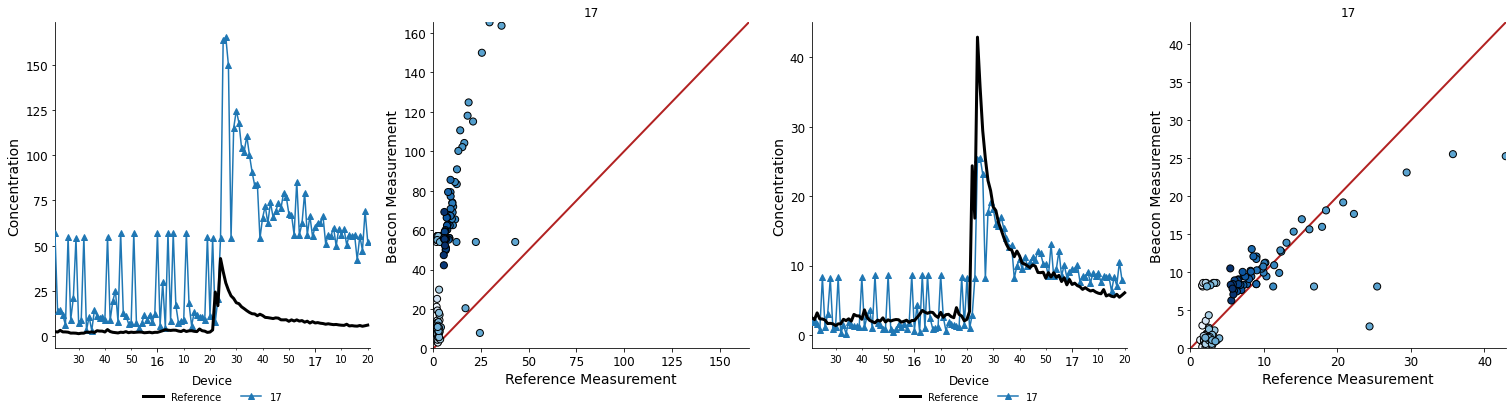

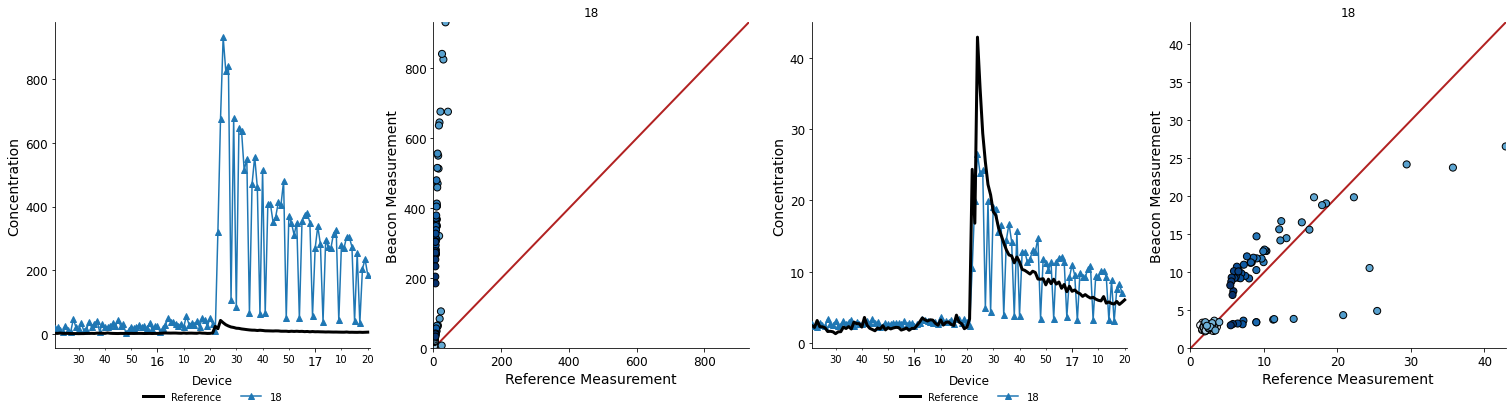

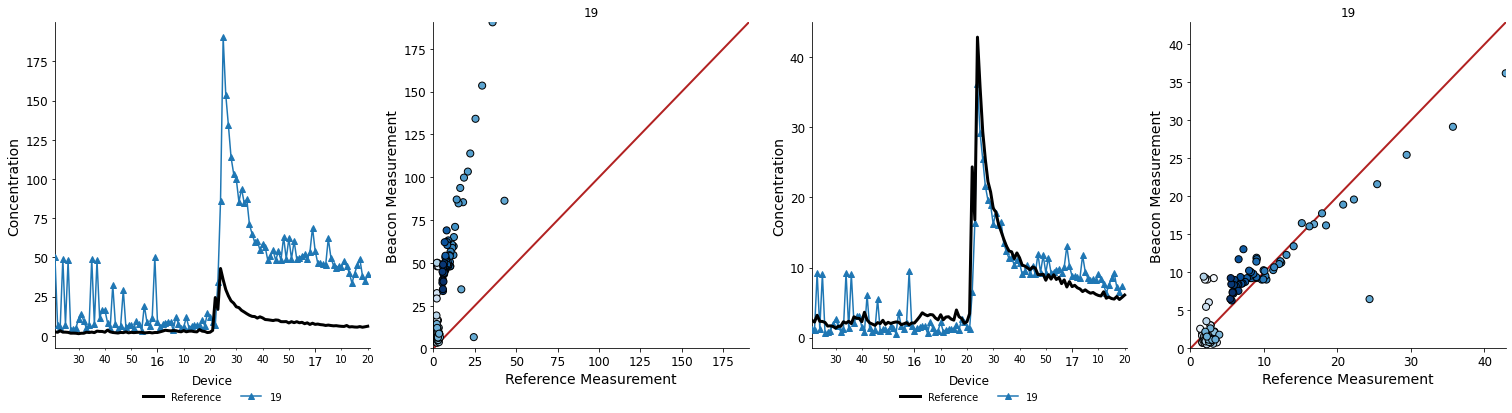

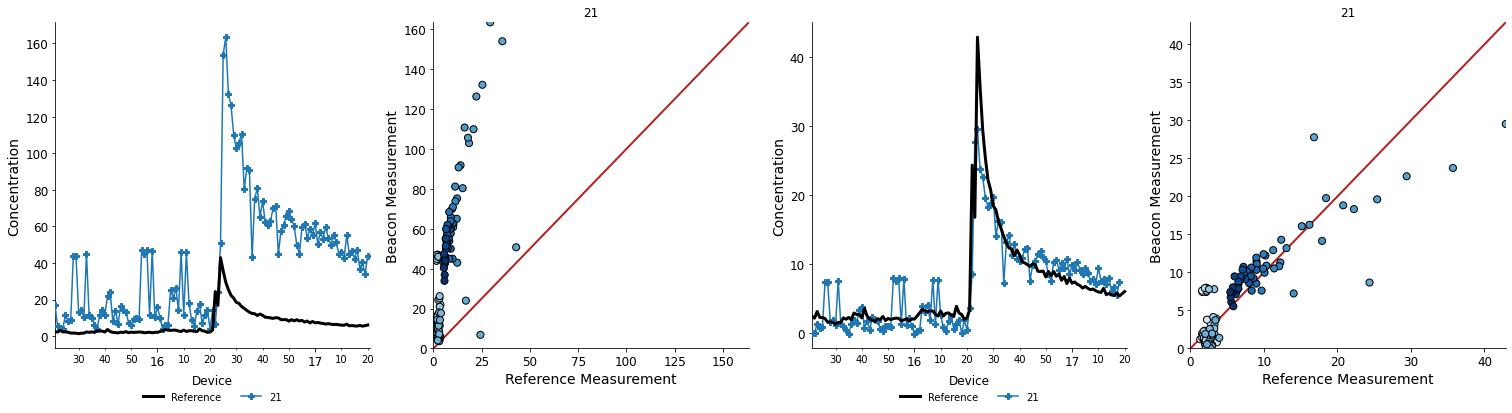

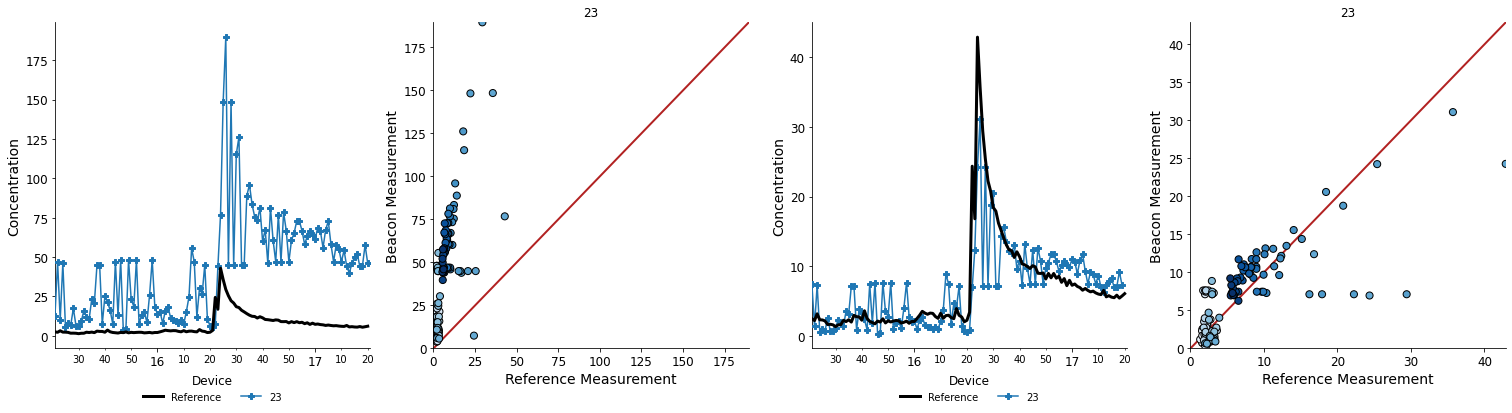

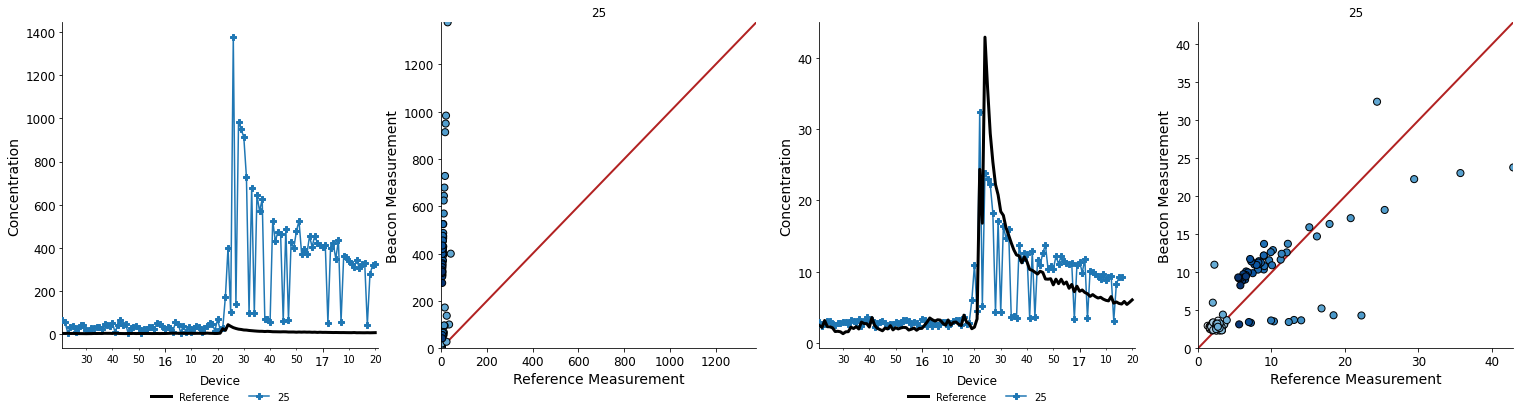

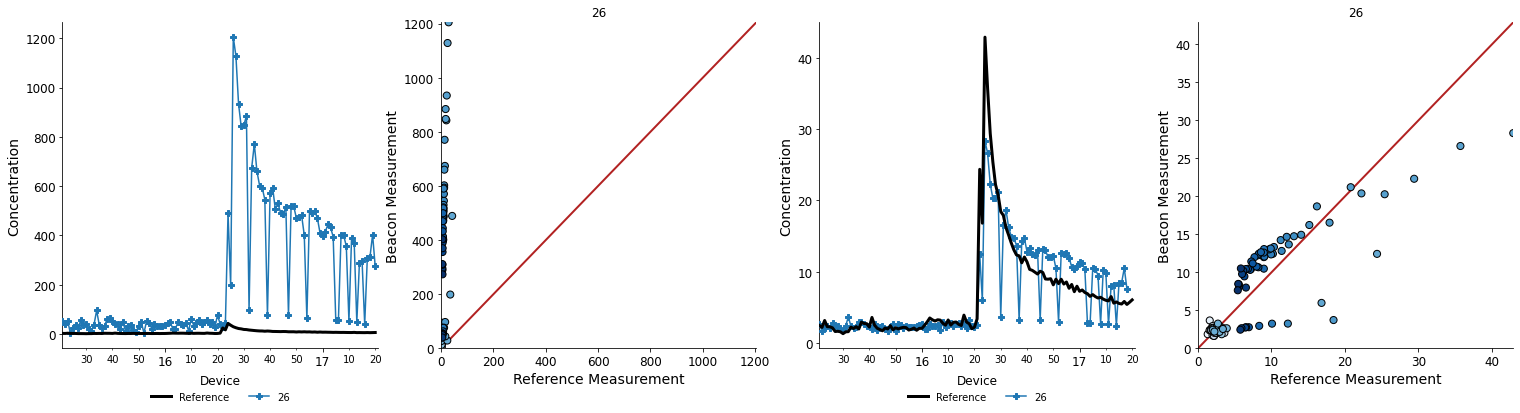

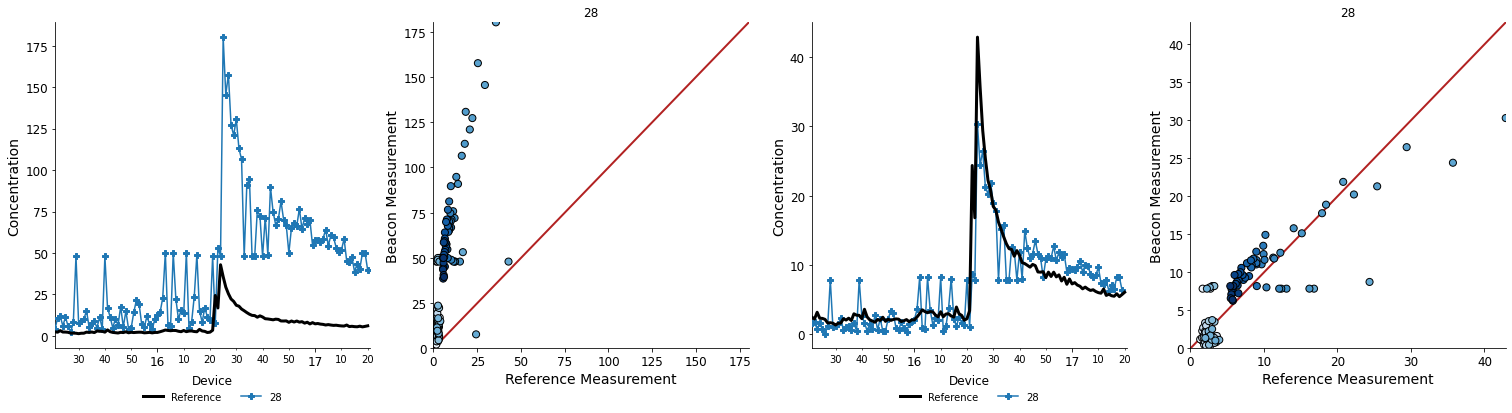

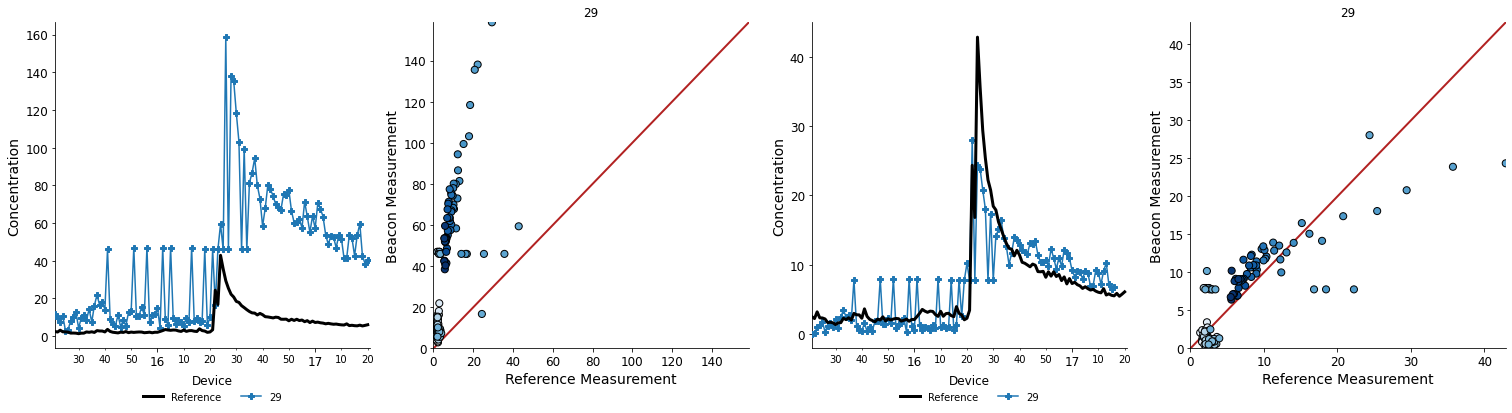

In [8]:
c.show_linear_correction("pm10_mass",min_val=0)